## Metaverse Transaction Data Analysis
 
### Anomaly classification (low_risk, medium_risk, high_risk) with meta transaction data

In [1]:
### Packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb
import warnings
import skopt
import lightgbm as lgb
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import train_test_split, HalvingGridSearchCV
from sklearn.metrics import confusion_matrix, classification_report
from skopt.space import Real, Categorical, Integer
from lightgbm import LGBMClassifier
import pickle
import os

### Other Options
warnings.filterwarnings("ignore")
plt.rcParams['figure.figsize'] = [10,5]
os.chdir('C:/Users/WulfN')

# Multiple Outputs Per Code Block 
%config InteractiveShell.ast_node_interactivity = 'all'


In [2]:
# Read in modeling dataframe

meta_model_df = pd.read_pickle('./Python Projects/Meta-Transaction-Risk-Classification/meta_model_df.pkl')

### Split modeling dataframe into training and validation set
- Creating function to generate downsampled training dataset
    - Validation set is not downsampled to ensure mode is robust on 'real-world' dataset
- Enter target variable to determine the training / validation data split
    - **target_variable = 'anomaly'**; multi-class, with equal representation across *low_risk*, *moderate_risk*, and *high_risk* classes.
    - **target_variable = 'binary_anomaly'**: binary, with equal representation across *low_moderate_risk* and *high_risk* classes
- Subsequent models will either be multi-class or binary classification models. 
- We are interested in assuring the model correctly classifies *high_risk* transactions
    - May then select either multi-class or binary classification model based on what classifies high_risk best


In [3]:
def class_train_val_split(target_variable):
       
       # Training Set and validation set
       df_x = meta_model_df.drop(columns = ['anomaly', 'anomaly_binary'])
       df_y = meta_model_df[target_variable] # as category?
       
       ### Train / Test split. Stratify by underrepresented class
       x_train, x_test, y_train, y_test = train_test_split(df_x, df_y, test_size = 0.25, stratify = df_y, random_state = 152)

       # Recombine Training sets to downsample
       training_sets = pd.concat([x_train, y_train], axis = 1)
       min_class_size = training_sets[target_variable].value_counts().min() # underepresented class (high risk) count
       print('Class Imbalance')
       print(training_sets[target_variable].value_counts())

       # Downsample training set to resolve problems with imbalanced data
       downsampled_train = (training_sets.groupby(target_variable, group_keys = False)
                            .apply(lambda x: 
                                   x.sample(n = min_class_size, random_state = 44, replace = True))
                            # Reshuffle 
                            .sample(frac = 1, random_state = 42))

       # Override training sets with downsampled versions
       x_train = downsampled_train.drop(columns = target_variable)
       y_train = downsampled_train[target_variable]

       print("\n")
       print('Training Set Class Balance')
       print(y_train.value_counts())

       print("\n")
       print('Validation Set Class Balance ')
       print(y_test.value_counts())
       return x_train, x_test, y_train, y_test


In [4]:
# Setting param for following methods that are dependent on the target variable
target_variable = 'anomaly_binary'

objective = 'binary' if target_variable == 'anomaly_binary' else 'multiclass'

# 'anomaly' or 'anomaly_binary' as input
x_train, x_test, y_train, y_test = class_train_val_split(target_variable)

Class Imbalance
anomaly_binary
0    54079
1     4871
Name: count, dtype: int64


Training Set Class Balance
anomaly_binary
1    4871
0    4871
Name: count, dtype: int64


Validation Set Class Balance 
anomaly_binary
0    18026
1     1624
Name: count, dtype: int64


- There exists a target class imbalance (47621 + 6458) to 4871
  - **Multiclass:** (*low_risk*: 47621, *moderate_risk*: 6458, *high_risk*: 4871)
  - **Binary:** (*low_moderate_risk*: 54079, *high_risk*: 4871)
  - Downsampling so that model accuracy is based on correctly identifying high risk transactions
- Retaining class imbalance on validation set to ensure model is accurate on 'real-world' datasets


### Halving Grid Search
- Using LightGBM
    - Model arguably superior to xgboost that performs well on diverse problems
    - Numerous parameters to lessen training time, and increase accuracy

In [7]:
def halving_lightgbm(objective): # 'binary' or 'multiclass'
   # Try HalvingGridSearch with Light GBM
   classifier = LGBMClassifier()
   param_grid = {'objective': [objective], 
               'learning_rate': [.05, .1, .2, .25, .4, .55, .75, 2], 
               'max_depth': [3, 4, 5, 6, 7, 8, 9, 10], 
               'feature_fraction': [.01, .1, .2, .3, .4, .5],
               'subsample': [.01, .1, .2, .3, .4, .5],
               'num_leaves': [2**4, 2**5, 2**6, 2**7], 
               'verbosity': [-1],
               'force_col_wise': [True]
               }


   # HalvingGridSearchCV
   halving_grid_search = (HalvingGridSearchCV(classifier, param_grid, cv = 2, random_state = 41, n_jobs = -1) 
                     .fit(x_train, y_train)); 

   # print(f"Best parameters for {classifier}:\n{halving_grid_search.best_params_}")
   # print(f"Best score: {halving_grid_search.best_score_:.4f}\n")

   return halving_grid_search


In [ ]:
%%capture 
# Objective is defined globally ('binary' or 'multiclass')
halving_grid_search = halving_lightgbm(objective)
halving_grid_search

Thoughts:
- HalvingGridSearchCV is difficult to implement with many Light GBM Params, such as boosting_type, early_stopping_round, or different training metrics.
- Requires an explicit grid search.
    - Constrains model to selected hyperparameter values
    - This may prevent model from reaching global optimum
- Resource efficient
    - Full set of hyperarameters in model grid are not tested
    - Prioritizes hyperparameters that improve accuracy

## Halving Grid Search Results on Validation Set

In [10]:
# Create feature importance plot given model predictions
def opt_model_feature_importance(model_output):

    # Feature Importance Plot
    opt_model = LGBMClassifier(**model_output.best_params_).fit(x_test, y_test)

    feature_importance = opt_model.feature_importances_
    feature_names = x_test.columns.to_list()

    importances_df = pd.DataFrame({"feature_names" : feature_names, 
                                "importances" : feature_importance})

    feature_importance_plot = sb.barplot(data = importances_df,
                                        x = feature_importance,
                                        y = feature_names,
                                        order = importances_df.sort_values('importances', ascending = False).feature_names)

    plt.title('Feature Importance Plot on Training Set')
    
    return feature_importance_plot

<Axes: title={'center': 'Feature Importance Plot on Training Set'}>

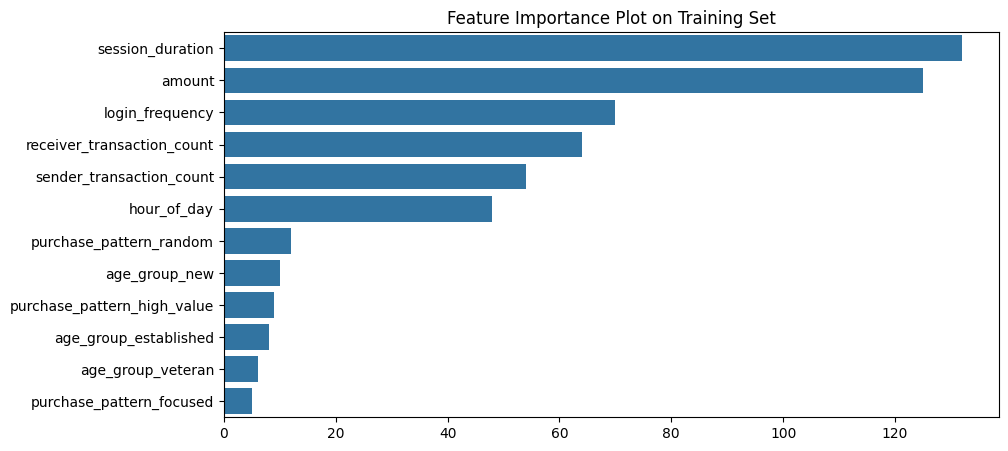

In [11]:
opt_model_feature_importance(halving_grid_search)

- engineered features (sender_transaction_count, receiver_transaction_count) explain a large amount of variation in the model
- Surprised to see hour_of_day being important given eda showing low std at hour level for all hours averaged throughout the year.

In [12]:
# Confusion Matrix Dependent on binary or multi-class output

def confusion_matrix_output(y_pred): #'binary' or 'multiclass'
    # Report and Confusion Matrix
    print(classification_report(y_test, y_pred))

    print('\n')

    if objective == 'binary': # Objective is define globally ('binary' or 'multiclass')
        class_labels = [0, 1]   

    else:    
        class_labels = ['low_risk', 'moderate_risk', 'high_risk']
    
    cm = confusion_matrix(y_test, y_pred, labels = class_labels) # Are these labels in the right order? 

    sb.heatmap(cm, annot = True, fmt = "d", cmap = "Blues", xticklabels = class_labels, yticklabels = class_labels)
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title('Confusion Matrix')
    plt.show(); 

              precision    recall  f1-score   support

           0       1.00      0.82      0.90     18026
           1       0.33      1.00      0.50      1624

    accuracy                           0.83     19650
   macro avg       0.67      0.91      0.70     19650
weighted avg       0.94      0.83      0.87     19650





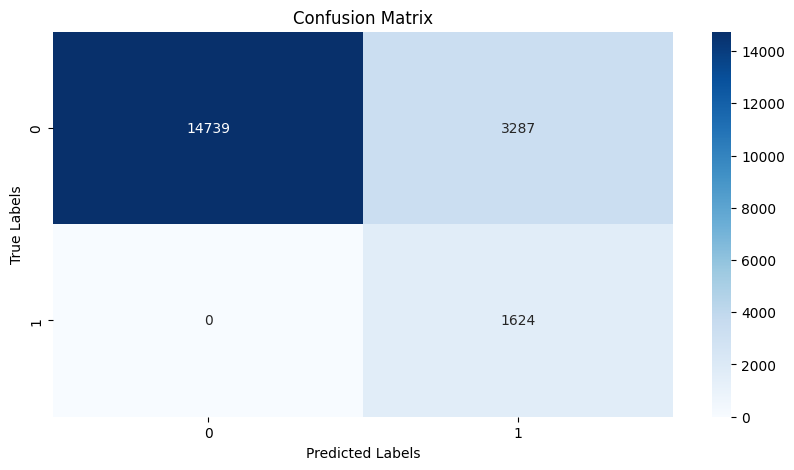

In [14]:
# Predicted values from optimized model 
y_pred = halving_grid_search.best_estimator_.predict(x_test)

confusion_matrix_output(y_pred)

### Validation Set Results
- Opting to create binary low-moderate risk (0) and high risk (1) target variable
  - multiclass target variable model performance
    - Accuracy: .79
    - Precision for moderate_risk: .7
    - Precision for high_risk: .33
    - Bonus of classifying moderate_risk transactions reasonably well, if important.
    - *Misclassified (2 + 6) = 8 high_risk transactions*
    
  - binary target variable model performance
    - Accuracy: .83
    - Precision for high_risk: .33
    - 3287 false positives
    - *Correctly identified ALL high-risk transactions*

- **Binary Model narrowly more effective at targeting high-risk transactions**
    - 33% of observations classified as high risk ARE high risk
      - Compared to 8.3% of observations in the validation set being high-risk
    - *Model identifies all high-risk transactions*


### Bayesian Optimization

In [49]:
### Trying BayesSearchCV 

def bayesian_lightgbm(objective): # 'binary' or 'multiclass'
    # Model Classifier
    classifier = LGBMClassifier()
    
    # Parameter Space
    param_space = {
    'objective': [objective],
    'learning_rate': Real(0.01, 1, prior = 'uniform'),
    'num_leaves': Integer(10, 50),
    'max_depth': Integer(3, 10),
    'boosting_type': Categorical(['gbdt', 'dart']),
    'feature_fraction': Real(0.1, 1, prior = 'uniform'),
    'subsample': Real(0.1, 1, prior = 'uniform'),
    'verbosity': [-1],
    'force_col_wise': [True]
    }

    # Bayesian Optimization with Cross Validation
    light_gbm_bayes_cv = skopt.BayesSearchCV(
        estimator = lgb.LGBMClassifier(),
        search_spaces = param_space,
        scoring = 'accuracy', 
        cv = 5,
        n_iter = 50, 
        n_jobs = -1,
        return_train_score = True,
        random_state = 42 
    ).fit(x_train, y_train); 

    # print('\n')
    # print(f"Best parameters for {classifier}:\n{light_gbm_bayes_cv.best_params_}")
    # print("Best Score:", light_gbm_bayes_cv.best_score_)
    
    return light_gbm_bayes_cv

In [52]:
%%capture 
bayes_opt_lightgbm = bayesian_lightgbm(objective)
bayes_opt_lightgbm

KeyboardInterrupt: 

## Bayesian Optimization Results

<Axes: title={'center': 'Feature Importance Plot on Training Set'}>

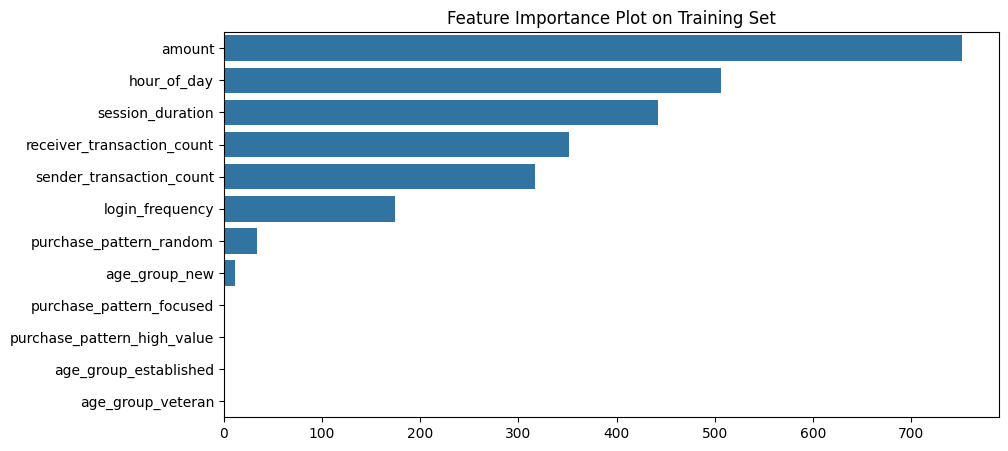

In [51]:
opt_model_feature_importance(bayes_opt_lightgbm)

- Same variables as halving grid search explain majority of variation in model, but ordered differently.
- Less importance is given to indicator variables

              precision    recall  f1-score   support

           0       1.00      0.82      0.90     18026
           1       0.33      0.99      0.50      1624

    accuracy                           0.83     19650
   macro avg       0.67      0.91      0.70     19650
weighted avg       0.94      0.83      0.87     19650





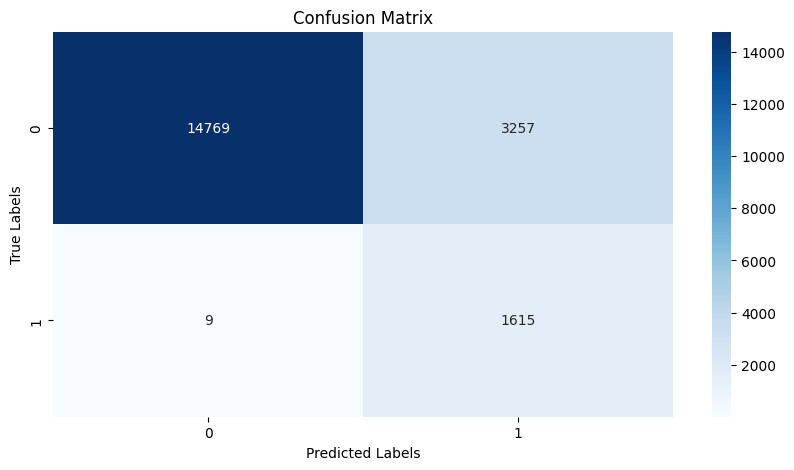

In [21]:
# Set y_pred from bayes search cv results
y_pred = bayes_opt_lightgbm.best_estimator_.predict(x_test)

#'binary' or 'multiclass'
confusion_matrix_output(y_pred)

### Validation Set Results
- Opting to create binary low-moderate risk (0) and high risk (1) target variable
  - multiclass target variable model performance
    - Accuracy: .79
    - Precision for moderate_risk: .69
    - Precision for high_risk: .33
    - Bonus of classifying moderate_risk transactions reasonably well, if important.
    - *Misclassified (17 + 35) = 52 high_risk transactions*
    
  - binary target variable model performance
    - Accuracy: .83
    - Precision for high_risk: .33
    - 3257 false positives (30 less than halving grid search)
    - *Misclassified 9 high-risk transactions*

- Similarly, the binary model is marginally better at identifying high-risk transactions.



### Halving Grid Search vs. Bayesian Grid Search Comparison
Which gave a better model for detecting high-risk transactions?
- **multi-class:** HalvingGridSearch
- **binary:** HalvingGridSearch

Other Notes:
- Other features engineered on risk_score or transaction type could substantially improve performance, but would not buildable on 'real world' data
    - In real world modeling, would seek additional data sources.
    - Non-Synthetic data may have more opportunities to engineer features that explain more variability 
- This is far from a thorough comparison. 
    - The parameter spaces were similar, but not identical
    - Results are from a single, synthetic data set.
- Bayesian Grid Search posed fewer coding challenges

___
## Using Scikit learn to Build Model Pipeline (Only Displaying Result for Binary Objective)
- Build 4 types of models
- Determine parameter space for each
- Select optimal parameters for each (with cross-validation)
- Show results of optimized models per model type


In [47]:
%%capture
# Testing Model Pipeline with Bayesian Optimization

from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline

# Define the models and their parameter spaces in a dictionary
models_and_param_spaces = {
    "KNN": { 
        "model": KNeighborsClassifier(),
        "param_space": {
            "model__n_neighbors": Integer(1, 30),
            "model__weights": Categorical(['uniform', 'distance']),
            "model__algorithm": Categorical(['ball_tree', 'kd_tree']),
            "model__metric": Categorical(['euclidean', 'manhattan'])
        }
    },
    "LogisticRegression": {
        "model": LogisticRegression(), 
        "param_space": {
            "model__solver": Categorical(['saga', 'lbfgs']),
            "model__C": Real(.01, 1, prior = 'uniform')
        }
    },
    "LightGBM": { 
        "model": lgb.LGBMClassifier(),
        "param_space": {
            "model__max_depth": Integer(1, 12),
            'model__learning_rate': Real(0.01, 1, prior = 'uniform'),
            'model__num_leaves': Integer(10, 50),
            'model__max_depth': Integer(3, 10),
            'model__boosting_type': Categorical(['gbdt', 'dart']),
            'model__feature_fraction': Real(0.1, 1, prior = 'uniform'),
            'model__subsample': Real(0.1, 1, prior = 'uniform'),
            'model__verbosity': [-1],
            'model__force_col_wise': [True]
        }
    },
    "RandomForest": { 
        "model": RandomForestClassifier(),
        "param_space": {
            "model__n_estimators": Integer(10, 30),
            "model__max_depth": Integer(1, 12),
            "model__min_samples_split": Integer(2, 20),
            "model__min_samples_leaf": Integer(4, 20),
        }
    }
}

# Perform BayesSearchCV for each model
results = {}
for name, config in models_and_param_spaces.items():
    # Set up pipeline 
    pipe = Pipeline([
        ('model', config['model'])
    ])
    
    # Define the BayesSearchCV object
    opt = skopt.BayesSearchCV(
        estimator = pipe,
        search_spaces = config['param_space'],
        n_iter = 32,  # Number of parameter settings sampled
        cv = 3,       # 3-fold cross-validation
        n_jobs = -1,  # Use all cores
        random_state = 100
    )
    
    # Fit the model
    opt.fit(x_train, y_train); 
    
    # Store the results
    results[name] = {
        "best_score": opt.best_score_,
        "best_params": opt.best_params_
    }

In [32]:
# Display the results
for model_name, result in results.items():
    print(f"{model_name} - Best Score: {result['best_score']:.4f}")
    print(f"Best Parameters: {result['best_params']}\n")

KNN - Best Score: 0.8777
Best Parameters: OrderedDict([('model__algorithm', 'ball_tree'), ('model__metric', 'manhattan'), ('model__n_neighbors', 10), ('model__weights', 'distance')])

LogisticRegression - Best Score: 0.8974
Best Parameters: OrderedDict([('model__C', 0.8184104191339556), ('model__solver', 'lbfgs')])

LightGBM - Best Score: 0.9049
Best Parameters: OrderedDict([('model__boosting_type', 'gbdt'), ('model__feature_fraction', 0.20194499998410062), ('model__force_col_wise', True), ('model__learning_rate', 0.4325319204713131), ('model__max_depth', 10), ('model__num_leaves', 26), ('model__subsample', 0.39719108827151306), ('model__verbosity', -1)])

RandomForest - Best Score: 0.9047
Best Parameters: OrderedDict([('model__max_depth', 4), ('model__min_samples_leaf', 10), ('model__min_samples_split', 15), ('model__n_estimators', 26)])



### Results on validation set

In [34]:
# Checking models with optimized parameters on the validation
KNN_model = KNeighborsClassifier(algorithm = 'ball_tree', metric = 'manhattan', n_neighbors = 10, weights = 'distance'); 
Log_model = LogisticRegression(C = 0.8184104191339556, solver = 'lbfgs'); 
LGBM_model = LGBMClassifier(boosting_type = 'gbdt', feature_fraction = 0.20194499998410062, verbosity = -1, force_col_wise = True,
                            learning_rate = 0.4325319204713131, max_depth = 10, num_leaves = 26, subsample = 0.39719108827151306); 
RF_model = RandomForestClassifier(max_depth = 4, min_samples_leaf = 10, min_samples_split = 15, n_estimators = 30);  

# Fit models on training set ...again (should be saved in the loop above instead)
KNN_val = KNN_model.fit(x_train, y_train)
Log_val = Log_model.fit(x_train, y_train)
RF_val = RF_model.fit(x_train, y_train)
LGBM_val = LGBM_model.fit(x_train, y_train)

# Generate predictions
KNN_pred = KNN_val.predict(x_test)
Log_pred = Log_val.predict(x_test)
RF_pred = RF_val.predict(x_test)
LGBM_pred = LGBM_val.predict(x_test)

KNN Model Confusion Matrix
              precision    recall  f1-score   support

           0       1.00      0.77      0.87     18026
           1       0.27      0.96      0.43      1624

    accuracy                           0.79     19650
   macro avg       0.63      0.87      0.65     19650
weighted avg       0.94      0.79      0.83     19650





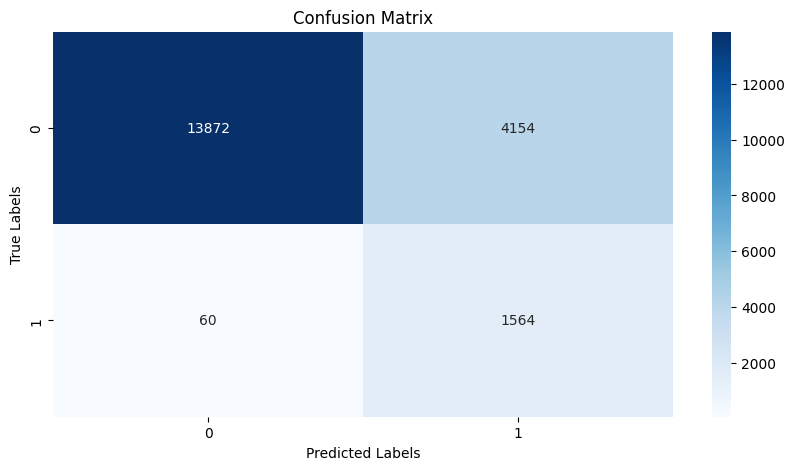



Logistic Regression Model Confusion Matrix
              precision    recall  f1-score   support

           0       1.00      0.81      0.89     18026
           1       0.32      0.99      0.48      1624

    accuracy                           0.82     19650
   macro avg       0.66      0.90      0.69     19650
weighted avg       0.94      0.82      0.86     19650





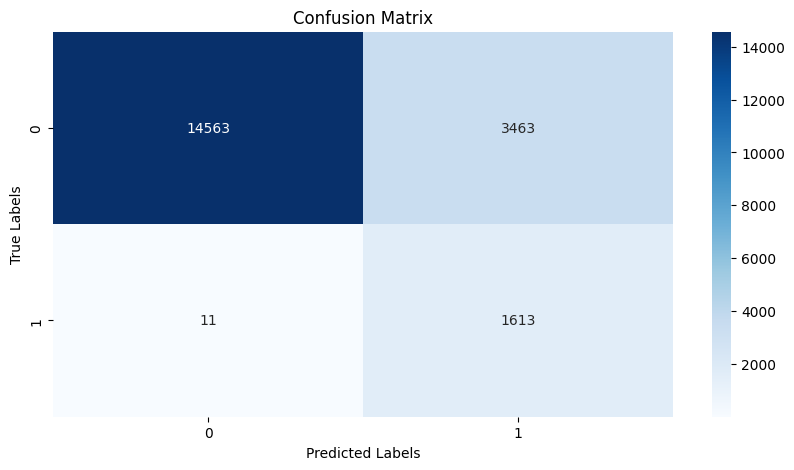



Random Forest Model Confusion Matrix
              precision    recall  f1-score   support

           0       1.00      0.82      0.90     18026
           1       0.33      1.00      0.50      1624

    accuracy                           0.83     19650
   macro avg       0.67      0.91      0.70     19650
weighted avg       0.94      0.83      0.87     19650





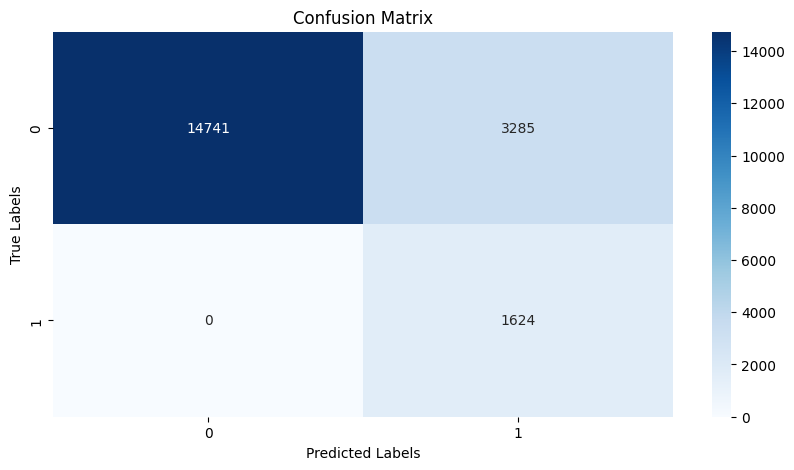



Light GBM Model Confusion Matrix
              precision    recall  f1-score   support

           0       1.00      0.82      0.90     18026
           1       0.33      0.99      0.50      1624

    accuracy                           0.83     19650
   macro avg       0.66      0.91      0.70     19650
weighted avg       0.94      0.83      0.87     19650





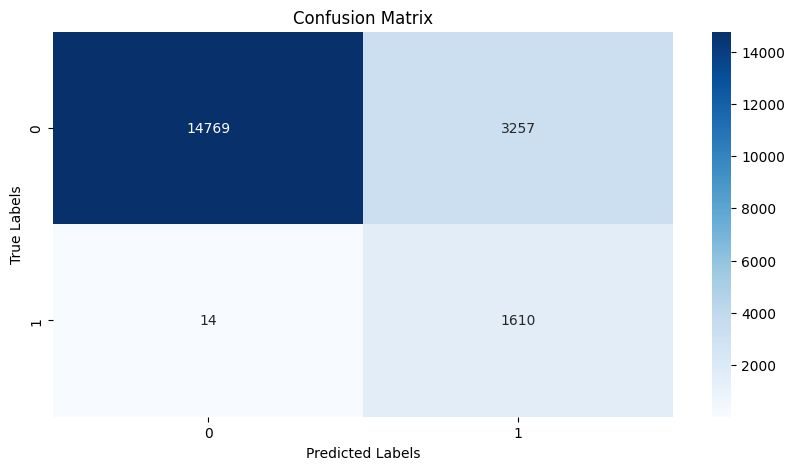

In [43]:
# Confusion Matrices for each model
print('KNN Model Confusion Matrix')
confusion_matrix_output(KNN_pred)
print('\n')
print('Logistic Regression Model Confusion Matrix')
confusion_matrix_output(Log_pred)
print('\n')
print('Random Forest Model Confusion Matrix')
confusion_matrix_output(RF_pred)
print('\n')
print('Light GBM Model Confusion Matrix')
confusion_matrix_output(LGBM_pred)

- Of these 4 models, Random Forest performs best
- LightGBM peforms slightly worse
    - Fewer rounds of cross validation
    - Different parameter space than prior Light GBM models
- Less sophisticated models (logistic regression and KNN) perform worse


### Ensemble Modeling
- Practice writing ensemble models with multi-model pipeline

In [36]:
from sklearn.ensemble import StackingClassifier, VotingClassifier

# ensemble using vote and stack method
ensemble_vote = VotingClassifier(
    estimators = [('KNN', KNN_model), ('Log', Log_model), ('RF', RF_model), ('LGBM', LGBM_model)],
    voting = 'soft'); 

ensemble_stack = StackingClassifier(
    estimators = [('KNN', KNN_model), ('Log', Log_model), ('RF', RF_model), ('LGBM', LGBM_model)],
    final_estimator = LGBMClassifier()); 

[LightGBM] [Info] Number of positive: 3896, number of negative: 3897
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000154 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1020
[LightGBM] [Info] Number of data points in the train set: 7793, number of used features: 4
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.499936 -> initscore=-0.000257
[LightGBM] [Info] Start training from score -0.000257
[LightGBM] [Info] Number of positive: 3897, number of negative: 3896
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000160 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1020
[LightGBM] [Info] Number of data points in the train set: 7793, number of used features: 4
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500064 -> initscore=0.000257
[LightGBM] [Info] Start training from score 0.000257
[LightGBM] [Info] Numb

[LightGBM] [Info] Number of positive: 4871, number of negative: 4871
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000179 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1020
[LightGBM] [Info] Number of data points in the train set: 9742, number of used features: 4
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
Voting Ensemble Confusion Matrix
              precision    recall  f1-score   support

           0       1.00      0.82      0.90     18026
           1       0.33      1.00      0.50      1624

    accuracy                           0.83     19650
   macro avg       0.67      0.91      0.70     19650
weighted avg       0.94      0.83      0.87     19650





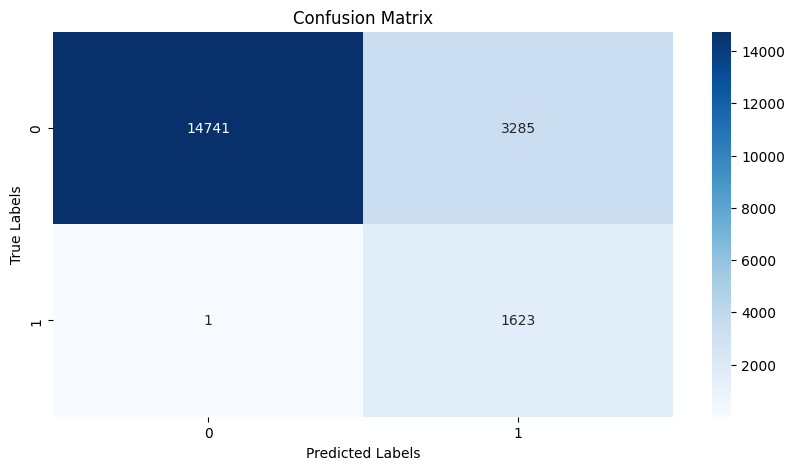



Stacking Ensemble Confusion Matrix
              precision    recall  f1-score   support

           0       0.99      0.83      0.90     18026
           1       0.33      0.94      0.49      1624

    accuracy                           0.84     19650
   macro avg       0.66      0.89      0.70     19650
weighted avg       0.94      0.84      0.87     19650





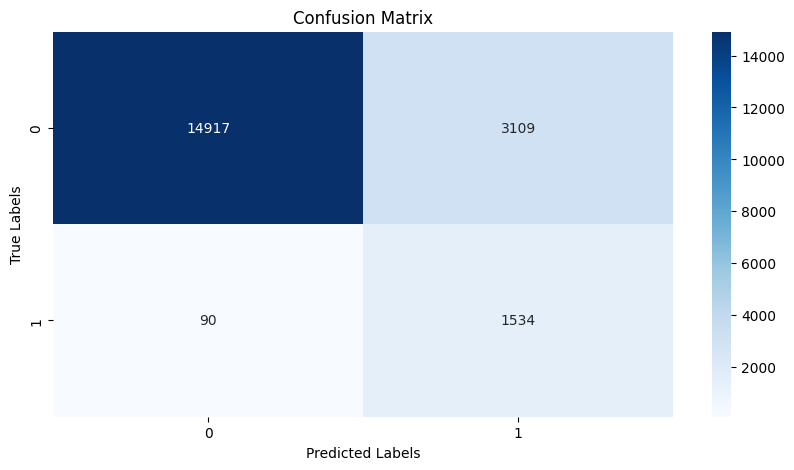

In [42]:
# Fit the ensemble models
ensemble_vote_fit = ensemble_vote.fit(x_train, y_train); 
ensemble_stack_fit = ensemble_stack.fit(x_train, y_train); 

# Predictions for ensemble models
vote_pred = ensemble_vote_fit.predict(x_test)
stack_pred = ensemble_stack_fit.predict(x_test)

# Confusion matrices for each ensemble model
print('Voting Ensemble Confusion Matrix')
confusion_matrix_output(vote_pred)
print('\n')
print('Stacking Ensemble Confusion Matrix')
confusion_matrix_output(stack_pred)

Voting and Stacking Ensemble Model Performance
- Both achieve marginally better accuracy than prior models
    - Ensemble with Voting:
        - Accuracy: .83
        - *Misclassified high-risk transactions: 1*
    - Ensemble with Stacking:
        - Accuracy: .84
        - *Misclassified high-risk transactions: 90*
